# Latents of MODIS_R2019_2010

In [1]:
%matplotlib inline

from importlib import reload
import os
import numpy as np
from pkg_resources import resource_filename

import pandas

import h5py
import seaborn as sns
import pandas as pd
#import umap
from ulmo import io as ulmo_io
from ulmo import plotting
from ulmo.ssl.my_util import modis_loader, set_model
from ulmo.ssl.my_util import Params, option_preprocess
from ulmo.ssl import latents_extraction

import torch

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
from tqdm import trange

In [2]:
#modis_R2019_data = '../experiments/datasets/modis_dataset/MODIS_R2019_2010_95clear_128x128_preproc_std.h5'
modis_R2019_data = '/data/Projects/Oceanography/AI/OOD/SST/MODIS_L2/PreProc/MODIS_R2019_2010_95clear_128x128_preproc_std.h5'

In [3]:
with h5py.File(modis_R2019_data, 'r') as f:
    modis_R2019 = f['train'][:]
modis_R2019.shape

(135712, 1, 64, 64)

In [4]:
# Down load the file
modis_R2019_latents = 's3://modis-l2/SSL_MODIS_R2019_2010_latents/modis_R2019_2010_latents_last.h5'
ulmo_io.download_file_from_s3(os.path.basename(modis_R2019_latents), modis_R2019_latents)

Done!


In [5]:
with h5py.File('modis_R2019_2010_latents_last.h5', 'r') as f:
    latents_R2019 = f['modis_latents'][:]
latents_R2019.shape

(135712, 256)

In [6]:
### Initialize the linear transformer at first
scaler = StandardScaler()
### Estimate the parameters
scaler.fit(latents_R2019)
### Transform the latents
latents_std = scaler.transform(latents_R2019)

In [7]:
import umap

In [8]:
%%time 
reducer_umap = umap.UMAP()
latents_reduced = reducer_umap.fit_transform(latents_std)

CPU times: user 13min 11s, sys: 2min 10s, total: 15min 22s
Wall time: 2min 5s


In [11]:
### Store the latents
save_path = './modis_R2019_latents_last.h5'
save_key = 'latents_train'
with h5py.File(save_path, 'w') as file:
    file.create_dataset(save_key, data=latents_reduced)

In [12]:
%%time
reducer_umap = umap.UMAP()
latents_mapping = reducer_umap.fit(latents_std)

CPU times: user 13min 6s, sys: 2min 9s, total: 15min 15s
Wall time: 1min 56s


In [13]:
import umap.plot

<AxesSubplot:>

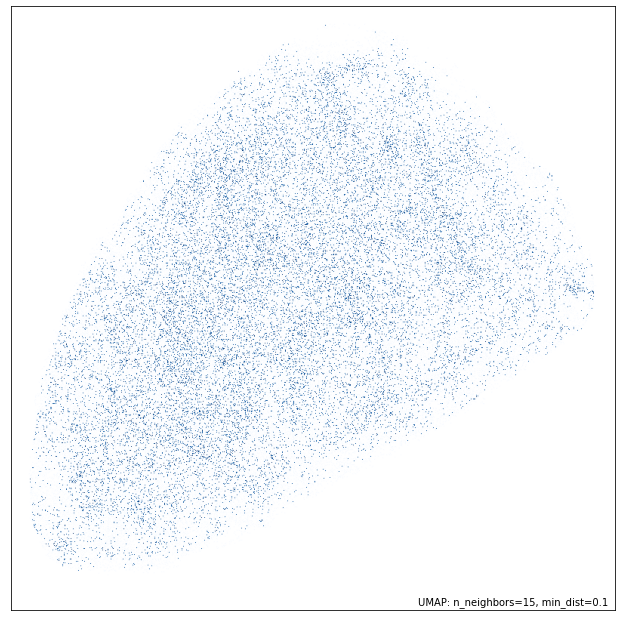

In [14]:
umap.plot.points(latents_mapping)

-----------------------------------------------

## Show the latents with the cutouts

In [23]:
from sklearn.neighbors import NearestNeighbors

In [24]:
nbrs = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(latents_reduced)
distances, indices = nbrs.kneighbors(latents_reduced)

In [25]:
### fix seed
np.random.seed(0)
indice_sampled = np.random.choice(indices.shape[0], 5)
indice_sets = indices[indice_sampled]
dist_sets = distances[indice_sampled]

In [26]:
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()

## Show the set 1

In [28]:
indice_sets[0]

array([ 43567,  81025,  60176, 122359, 119221,   7513,  63693,  49931,
        52544, 103244, 111080,  28086,  25801,  35032,  20298, 107217,
       123164,  73128,  11020,  37843])

In [29]:
imgs_set = modis_R2019[indice_sets[0]]
dist_set = dist_sets[0]

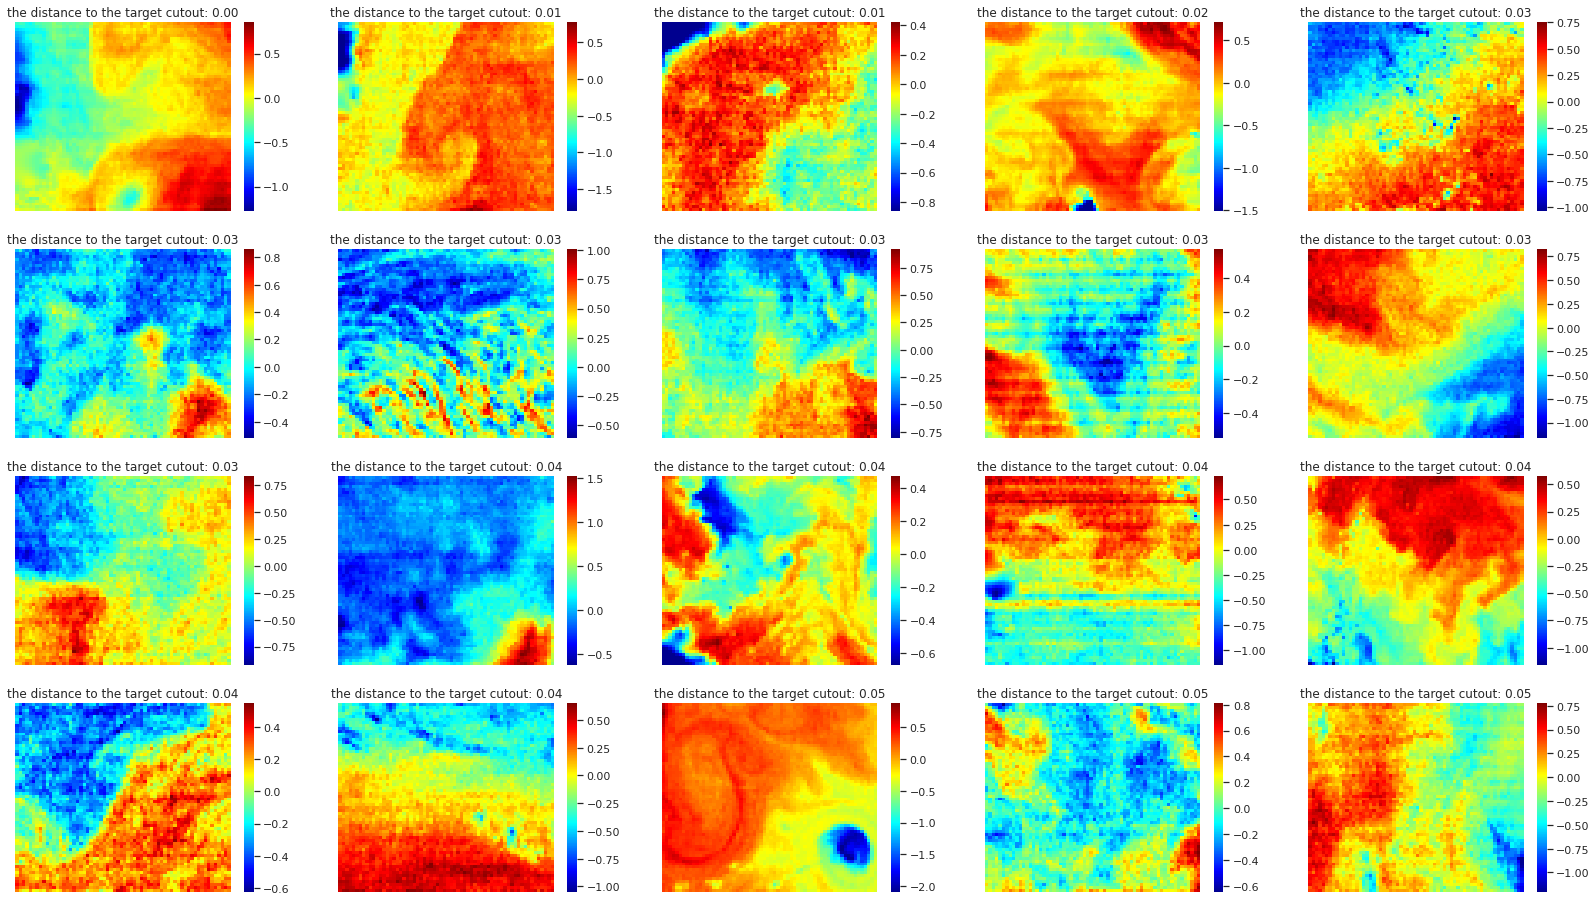

In [30]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

## Show the set 2

In [31]:
imgs_set = modis_R2019[indice_sets[1]]
dist_set = dist_sets[1]

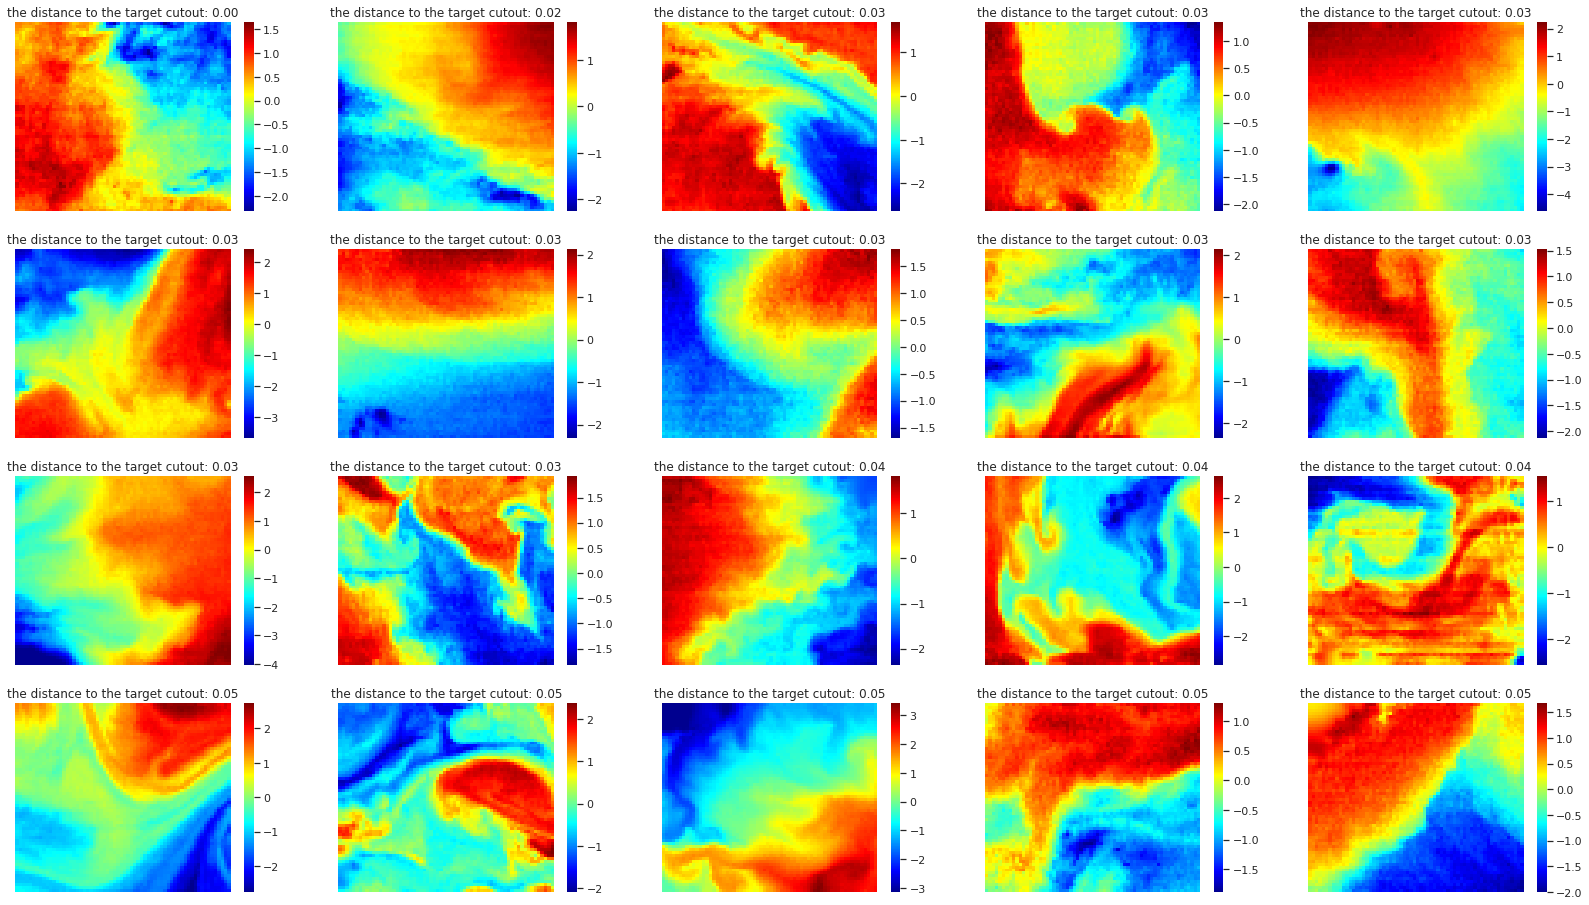

In [32]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

## Show the set 3

In [33]:
imgs_set = modis_R2019[indice_sets[2]]
dist_set = dist_sets[2]

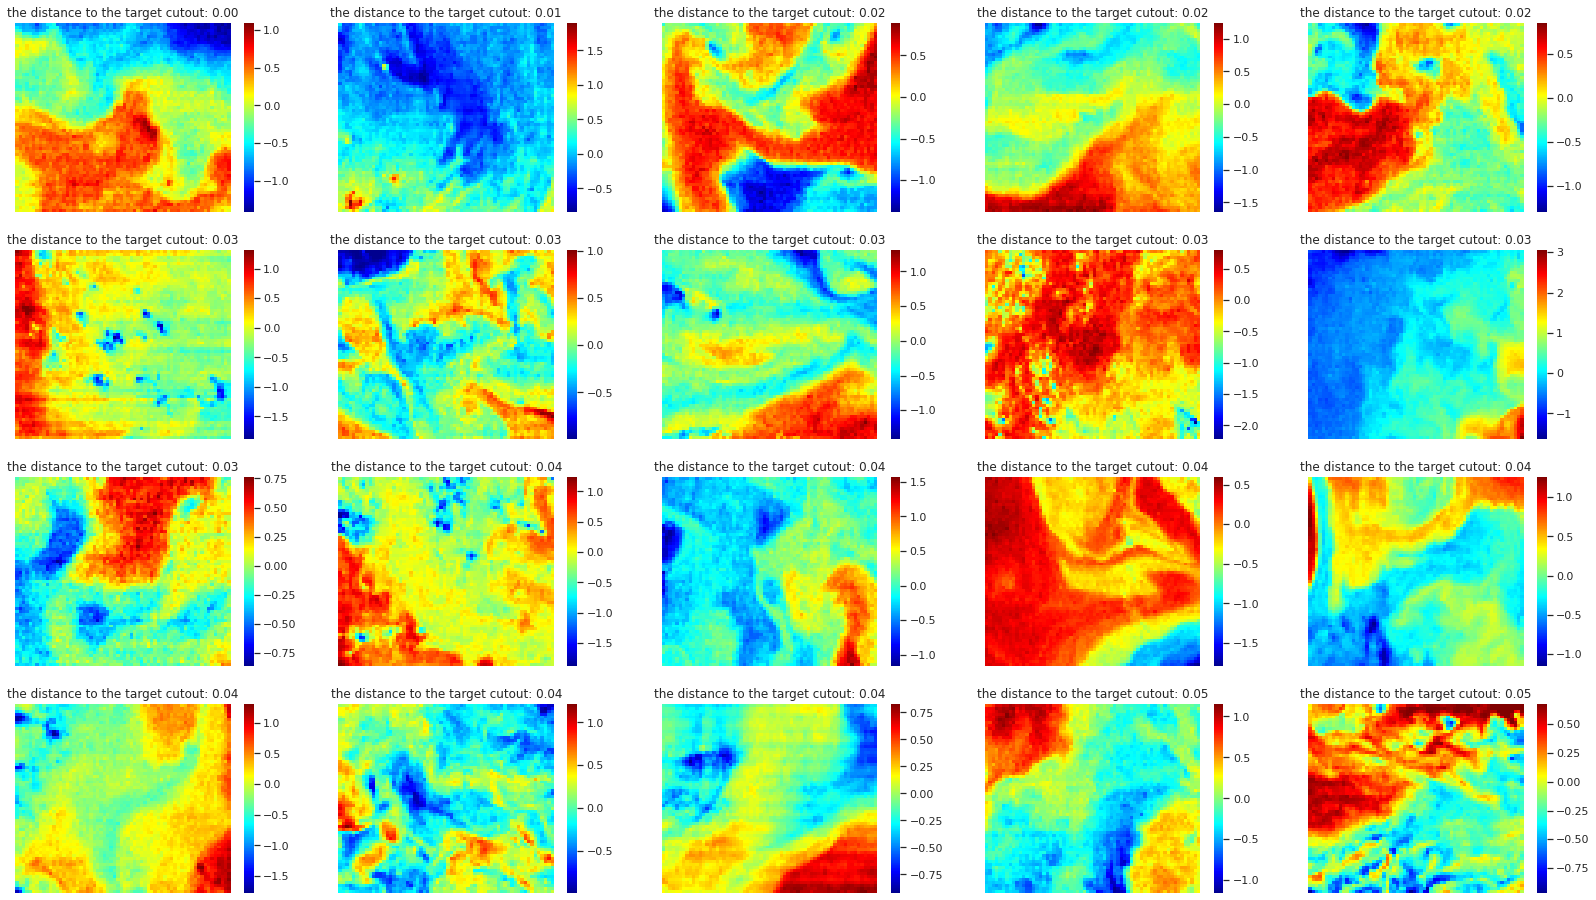

In [34]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

## Show the set 4

In [34]:
imgs_set = modis_R2019[indice_sets[3]]
dist_set = dist_sets[3]

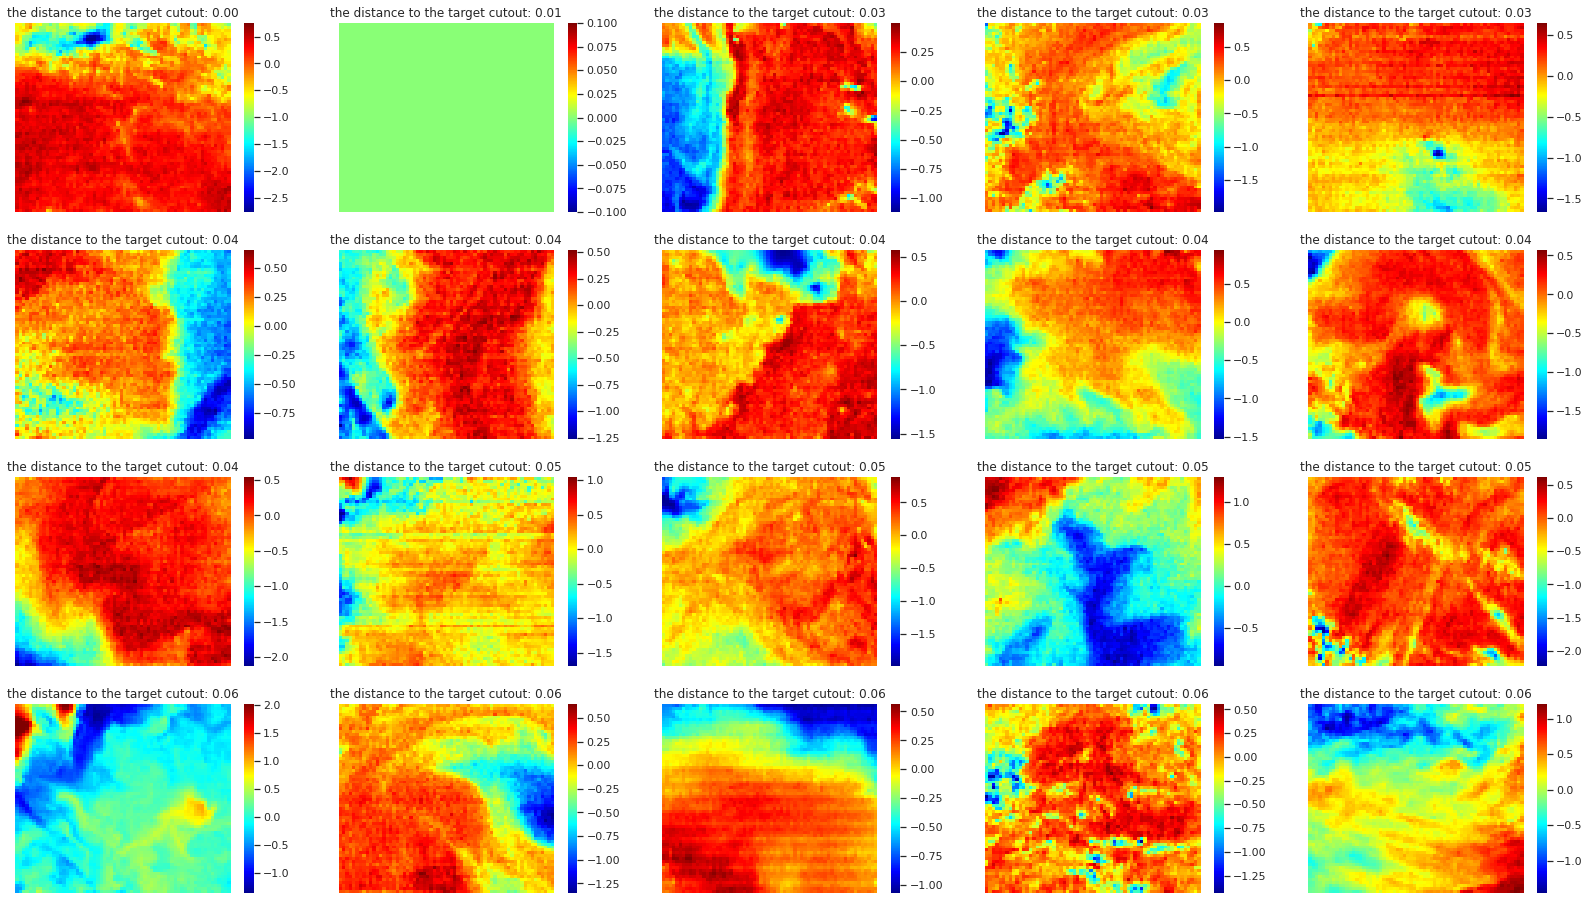

In [35]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

## Show the set 5

In [38]:
imgs_set = modis_R2019[indice_sets[4]]
dist_set = dist_sets[4]

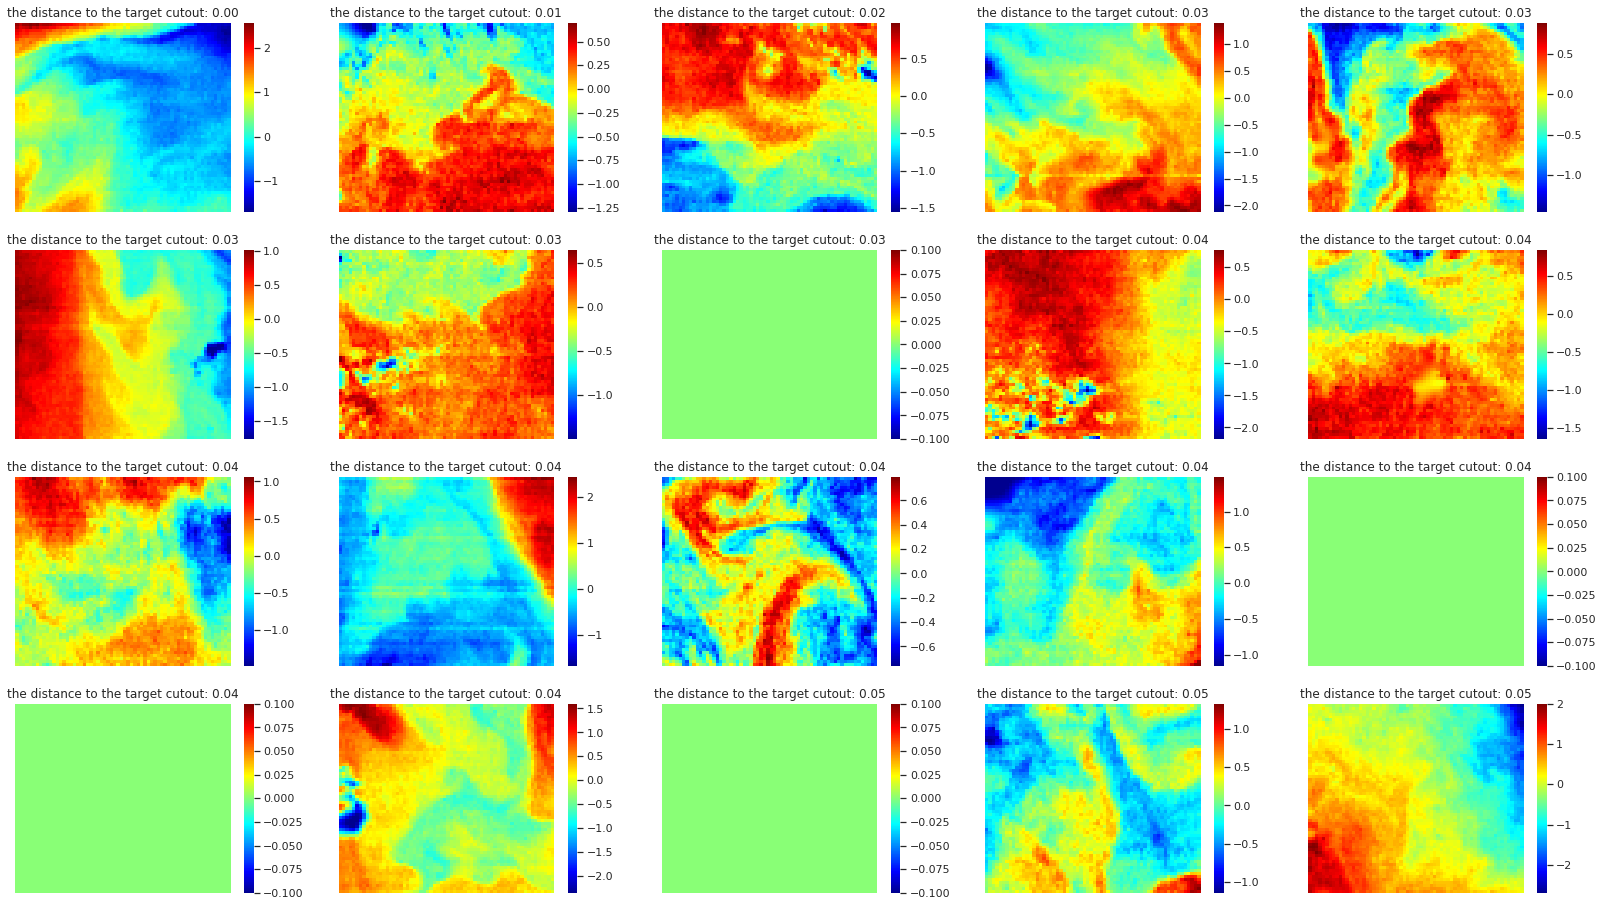

In [39]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

# Show the Scatter plot with cutouts

In [38]:
latents_list = [latents_reduced[i, :] for i in indice_sets[0]]

In [3]:
### Store the latents
save_path = './experiments/modis_R2019_latents_last.h5'
save_key = 'latents_train'
with h5py.File(save_path, 'r') as file:
    latents_reduced = file[save_key][:]

In [35]:
num_samples = latents_reduced.shape[0]
point_size = 100.0 / np.sqrt(num_samples)
width, height = 800, 800
dpi = 100

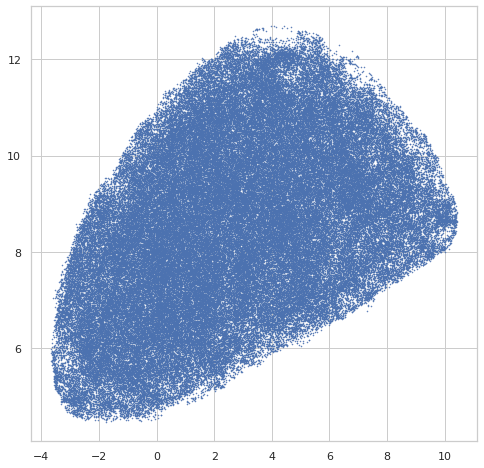

In [36]:
plt.figure(figsize=(width//dpi, height//dpi))
plt.scatter(latents_reduced[:, 0], latents_reduced[:, 1], s=point_size)

In [39]:
x_latents_list = [latents_list[i][0] for i in range(20)]
y_latents_list = [latents_list[i][1] for i in range(20)]

In [40]:
x_min, x_max = min(x_latents_list), max(x_latents_list)
y_min, y_max = min(y_latents_list), max(y_latents_list)

In [41]:
len_square = x_max - x_min
height_square = y_max - y_min
x_square = (x_min + x_max) / 2
y_square = (y_min + y_max) / 2

In [42]:
from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.patches import Rectangle
from matplotlib.cbook import get_sample_data

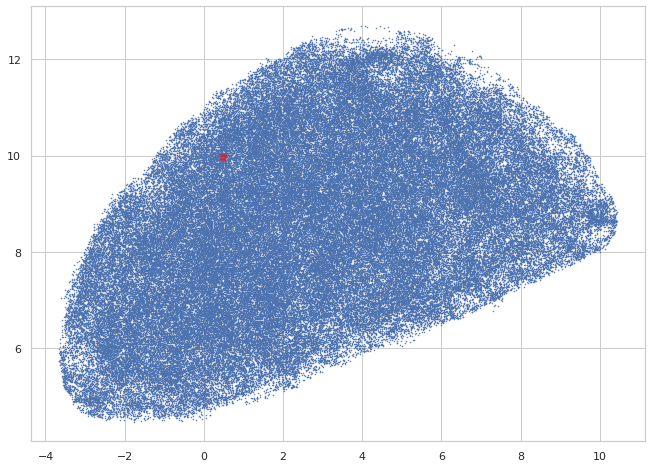

In [43]:
### set the plot of sns 
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()
fig, ax = plt.subplots(figsize=(11, 8))
plt.scatter(latents_reduced[:, 0], latents_reduced[:, 1], s=point_size)
ax.add_patch(Rectangle((x_square, y_square),
                        len_square, height_square,
                        fc ='none', 
                        ec ='red',
                        lw = 2.5, 
                        alpha=0.6))

In [44]:
#####################################################################
### plot the cutouts
width, step = 73, 34.5 / 16
x_box, y_box = -40., -440.
ab_list = []
for i in range(5):
    x_box_i = x_box + i * (width + step)
    xybox = (x_box_i, ybox)
    imagebox = OffsetImage(img_modis_list[i], zoom=1)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, xy, 
                        xybox, 
                        xycoords='data', 
                        boxcoords='offset points', 
                        pad=0.3)
    ax.add_artist(ab)
#y_box = y_box - width
for i in range(5, 10):
    x_box_i = x_box + i * (width + step)
    xybox = (x_box_i, ybox)
    imagebox = OffsetImage(img_modis_list[i], zoom=1)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, xy, 
                        xybox, 
                        xycoords='data', 
                        boxcoords='offset points', 
                        pad=0.3)
    ax.add_artist(ab)

NameError: name 'ybox' is not defined

In [45]:
imgs_set = modis_R2019[indice_sets[0]]
dist_set = dist_sets[0]

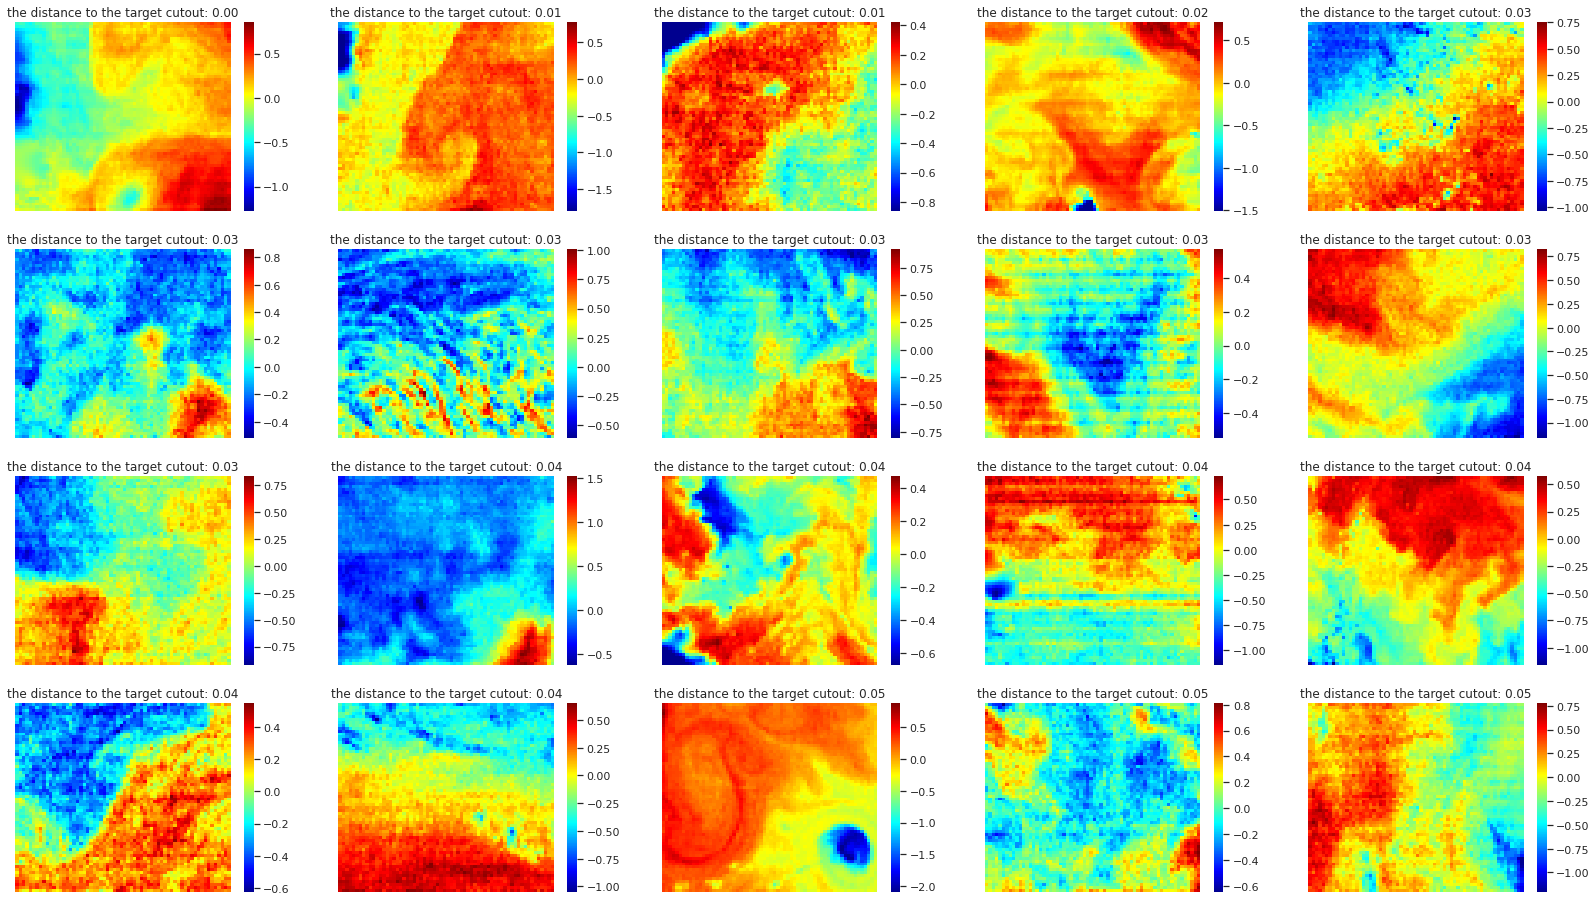

In [46]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

In [47]:
imgs_set = modis_R2019[indice_sets[1]]
dist_set = dist_sets[1]

In [48]:
latents_list = [latents_reduced[i, :] for i in indice_sets[1]]

In [49]:
x_latents_list = [latents_list[i][0] for i in range(20)]
y_latents_list = [latents_list[i][1] for i in range(20)]

In [50]:
x_min, x_max = min(x_latents_list), max(x_latents_list)
y_min, y_max = min(y_latents_list), max(y_latents_list)

In [51]:
len_square = x_max - x_min
height_square = y_max - y_min
x_square = (x_min + x_max) / 2
y_square = (y_min + y_max) / 2

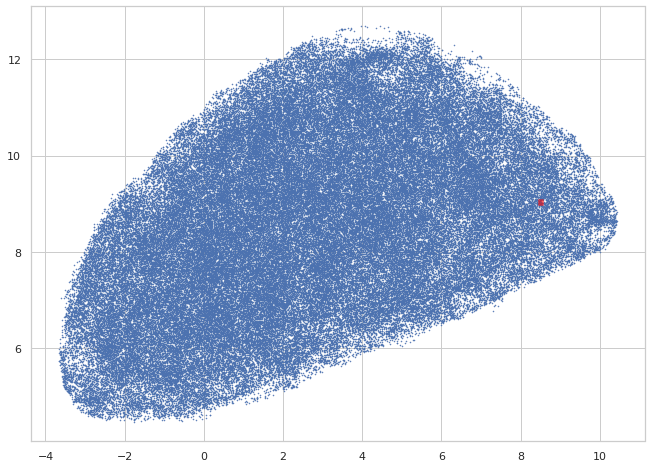

In [52]:
### set the plot of sns 
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()
fig, ax = plt.subplots(figsize=(11, 8))
plt.scatter(latents_reduced[:, 0], latents_reduced[:, 1], s=point_size)
ax.add_patch(Rectangle((x_square, y_square),
                        len_square, height_square,
                        fc ='none', 
                        ec ='red',
                        lw = 2.5, 
                        alpha=0.6))

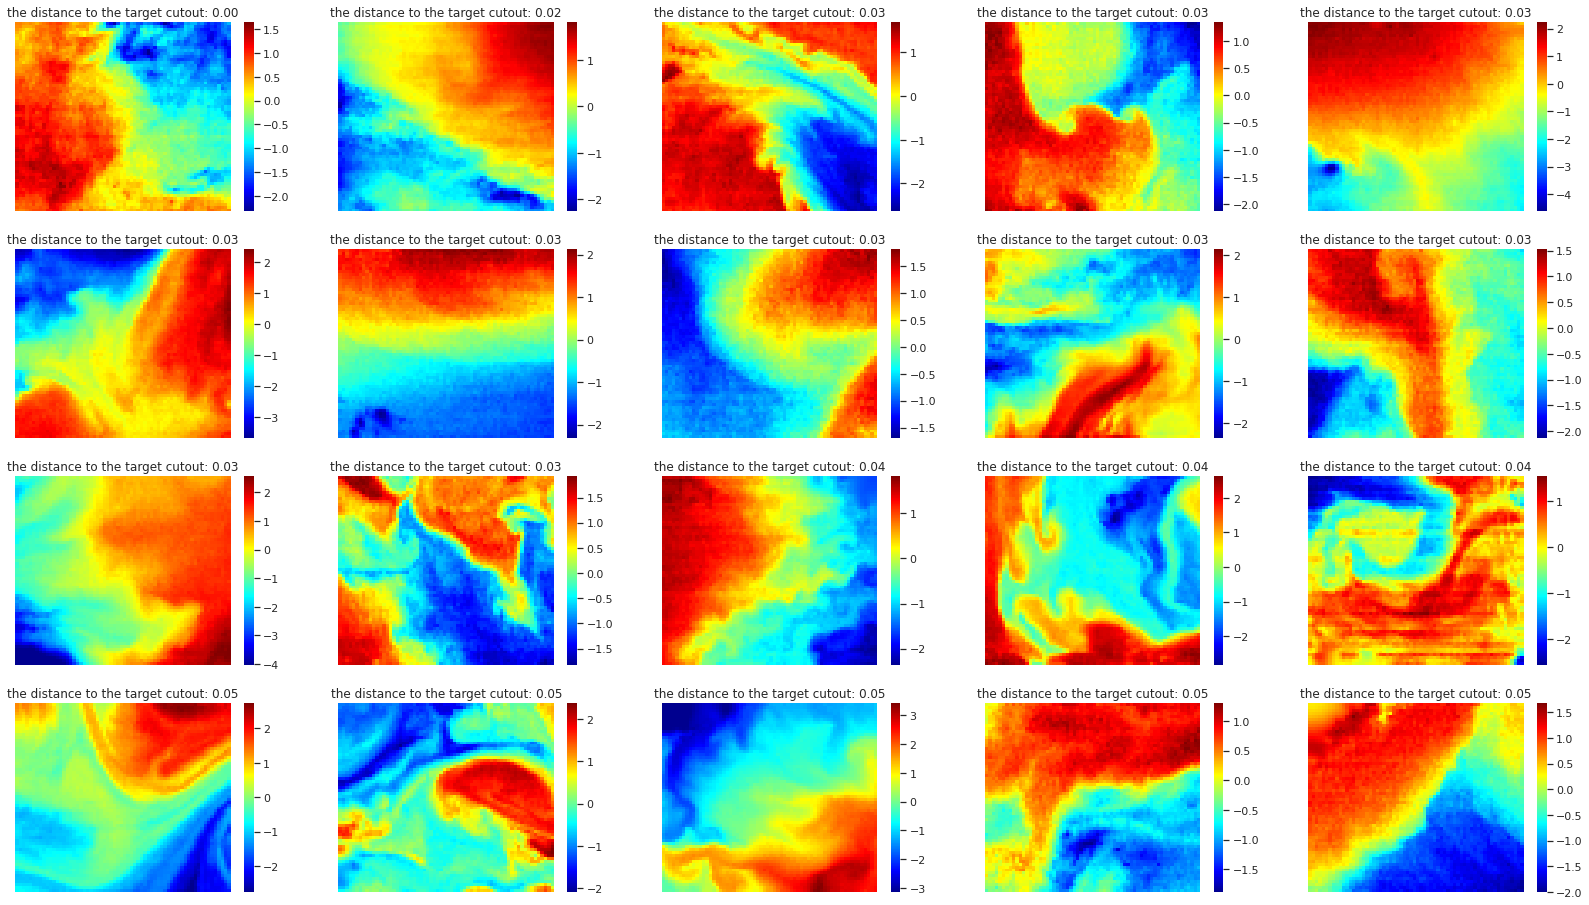

In [53]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

In [48]:
imgs_set = modis_R2019[indice_sets[2]]
dist_set = dist_sets[2]

In [49]:
latents_list = [latents_reduced[i, :] for i in indice_sets[2]]

In [50]:
x_latents_list = [latents_list[i][0] for i in range(20)]
y_latents_list = [latents_list[i][1] for i in range(20)]

In [51]:
x_min, x_max = min(x_latents_list), max(x_latents_list)
y_min, y_max = min(y_latents_list), max(y_latents_list)

In [52]:
len_square = x_max - x_min
height_square = y_max - y_min
x_square = (x_min + x_max) / 2
y_square = (y_min + y_max) / 2

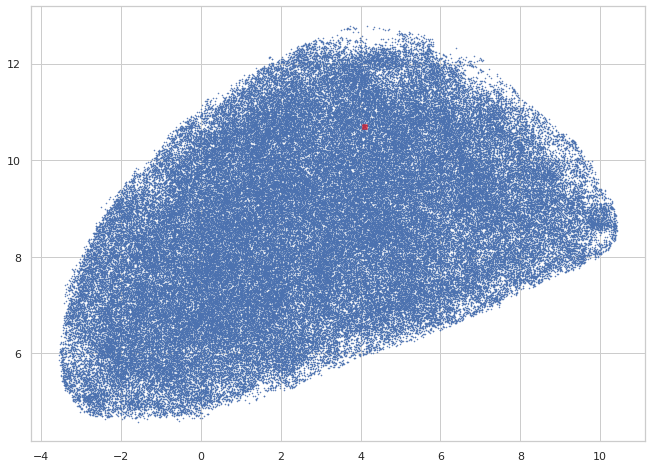

In [53]:
### set the plot of sns 
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()
fig, ax = plt.subplots(figsize=(11, 8))
plt.scatter(latents_reduced[:, 0], latents_reduced[:, 1], s=point_size)
ax.add_patch(Rectangle((x_square, y_square),
                        len_square, height_square,
                        fc ='none', 
                        ec ='red',
                        lw = 2.5, 
                        alpha=0.6))

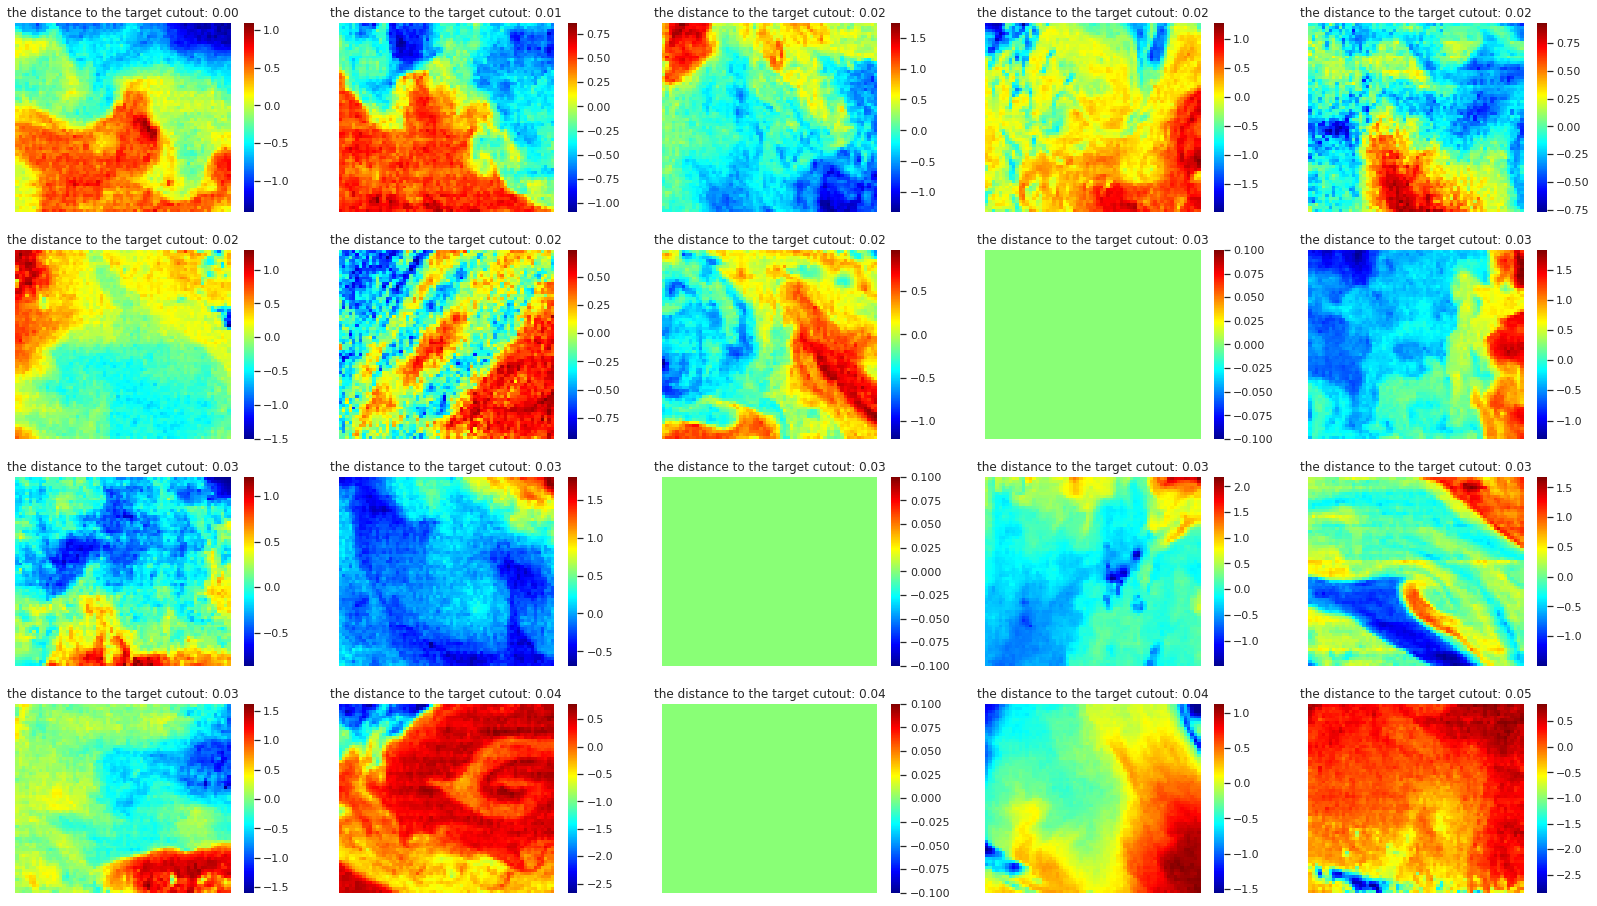

In [54]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

In [55]:
imgs_set = modis_R2019[indice_sets[3]]
dist_set = dist_sets[3]

In [56]:
latents_list = [latents_reduced[i, :] for i in indice_sets[3]]

In [57]:
x_latents_list = [latents_list[i][0] for i in range(20)]
y_latents_list = [latents_list[i][1] for i in range(20)]

In [58]:
x_min, x_max = min(x_latents_list), max(x_latents_list)
y_min, y_max = min(y_latents_list), max(y_latents_list)

In [59]:
len_square = x_max - x_min
height_square = y_max - y_min
x_square = (x_min + x_max) / 2
y_square = (y_min + y_max) / 2

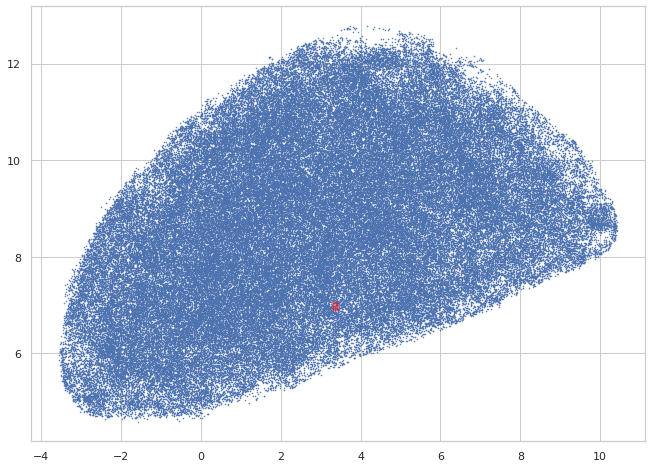

In [60]:
### set the plot of sns 
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()
fig, ax = plt.subplots(figsize=(11, 8))
plt.scatter(latents_reduced[:, 0], latents_reduced[:, 1], s=point_size)
ax.add_patch(Rectangle((x_square, y_square),
                        len_square, height_square,
                        fc ='none', 
                        ec ='red',
                        lw = 2.5, 
                        alpha=0.6))

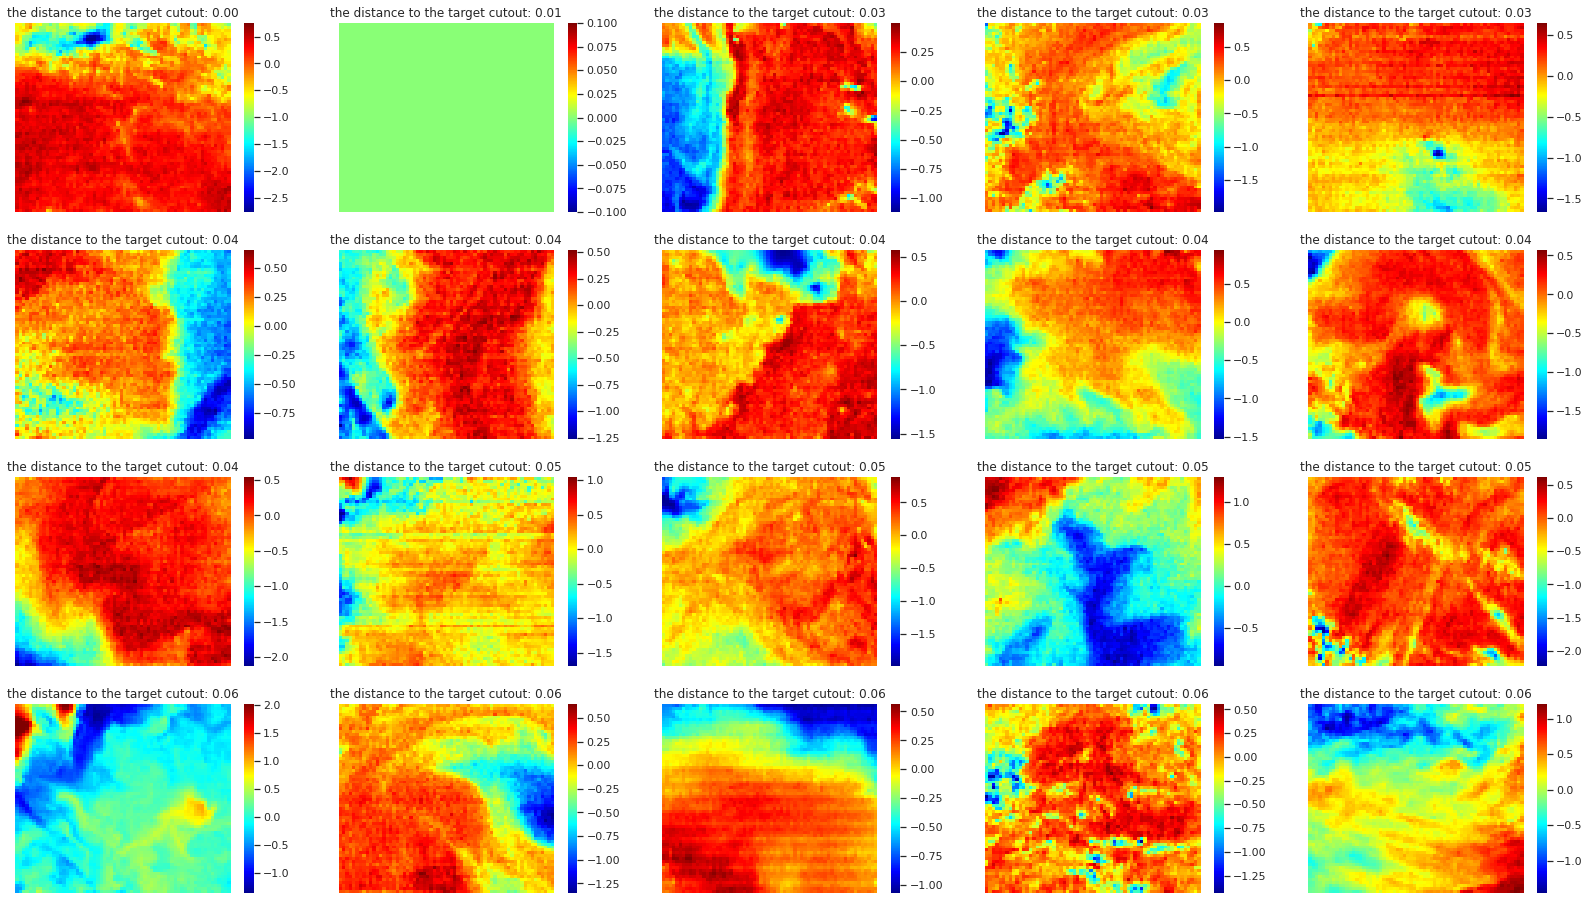

In [61]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

In [62]:
imgs_set = modis_R2019[indice_sets[4]]
dist_set = dist_sets[4]

In [63]:
latents_list = [latents_reduced[i, :] for i in indice_sets[4]]

In [64]:
x_latents_list = [latents_list[i][0] for i in range(20)]
y_latents_list = [latents_list[i][1] for i in range(20)]

In [65]:
x_min, x_max = min(x_latents_list), max(x_latents_list)
y_min, y_max = min(y_latents_list), max(y_latents_list)

In [66]:
len_square = x_max - x_min
height_square = y_max - y_min
x_square = (x_min + x_max) / 2
y_square = (y_min + y_max) / 2

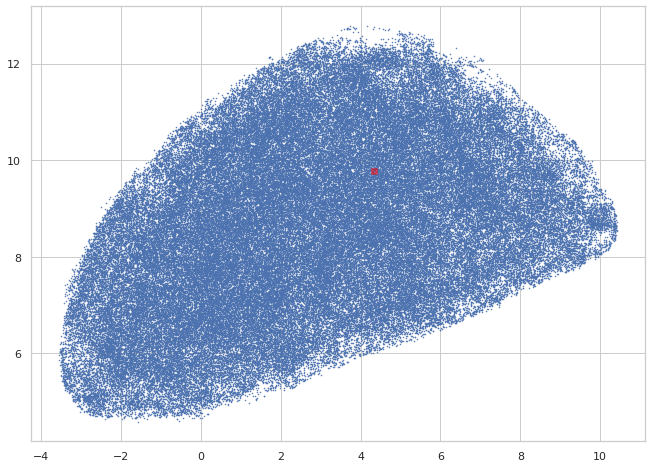

In [67]:
### set the plot of sns 
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()
fig, ax = plt.subplots(figsize=(11, 8))
plt.scatter(latents_reduced[:, 0], latents_reduced[:, 1], s=point_size)
ax.add_patch(Rectangle((x_square, y_square),
                        len_square, height_square,
                        fc ='none', 
                        ec ='red',
                        lw = 2.5, 
                        alpha=0.6))

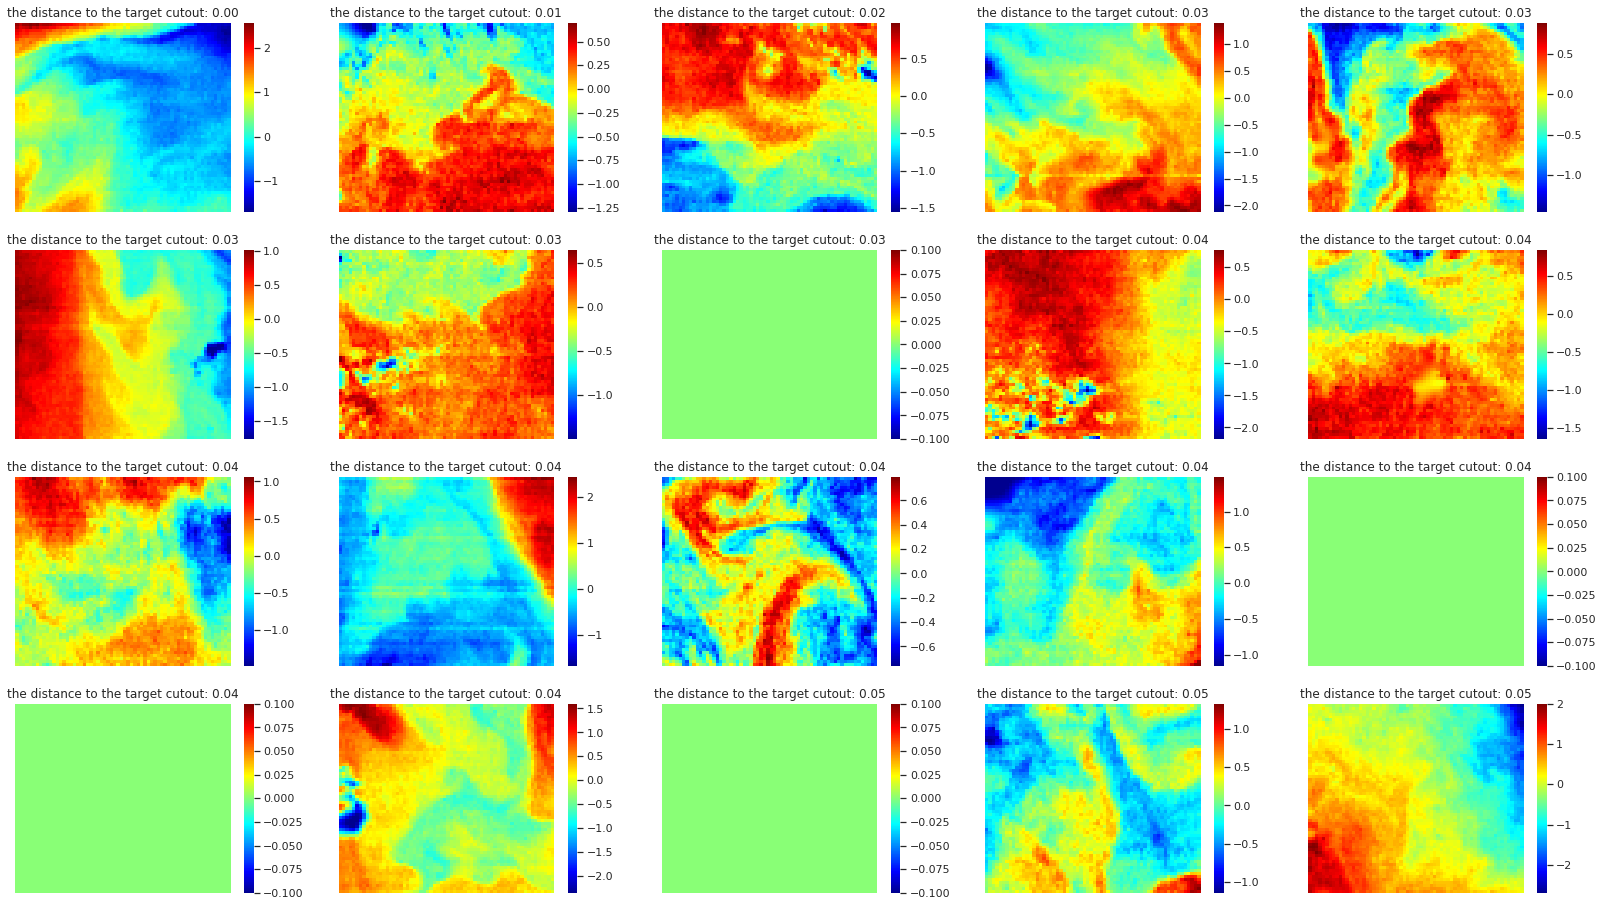

In [68]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')